# 4.2 Text Classification with PyTorch - Custom Pre Preprocessing

In [25]:
import torch
import pandas as pd

In [26]:
df = pd.read_csv('../data/merged_plots.csv', index_col=0)
df

,title,plot,is_indian
0,10.0 Earthquake,As a series of minor earthquakes start tearing...,0
1,12 Rounds (film),A sting operation to capture arms dealer Miles...,0
2,12 Rounds 3: Lockdown,Detective Tyler Burke and his two men infiltr...,0
3,200 mph,When the older brother (Tommy Nash) he idolize...,0
4,Ablaze (2001 film),Andrew Thomas is an agent tasked with recordin...,0
...,...,...,...
3995,Choked (film),Sarita Pillai and Sushant Pillai are a married...,1
3996,Chumbak,"Chumbak is a coming-of-age story of Baalu, a t...",1
3997,Chungakkarum Veshyakalum,Chungakkarum Veshyakalum is the story of a Mal...,1
3998,Chuzhi,Varghese is a planter who lives with his wife ...,1


In [27]:
value_tuples = []
for row in df.iterrows():
    values = row[1]
    value_tuples.append((values['is_indian'], values['plot']))

print(len(value_tuples))
print(value_tuples[0])
print(value_tuples[-1])

4000
(0, 'As a series of minor earthquakes start tearing apart Los Angeles, scientist Emily of the USGS theorizes that it is all building to a super quake that will drop the entire city into a lava-filled chasm. Engineer Jack whose daughter has gone camping with her friends in the danger area and whose company is responsible for the quakes due to their deep fracking feels obligated to help, and races with Emily through the increasingly damaged city with the hopes of diverting the epicenter to Long Beach and potentially saving millions of lives in the city of Los Angeles.')
(1, 'Jaya is a cinephile. So obsessed is she with cinema, that she worships the popular actor Jaishankar, believing all that he portrays on screen, to be his real self. He becomes the ideal man of her dreams, and she even tattoos his name in her arm. Hell breaks loose when she refuses to marry Natarajan, the boy arranged by her brother and her sister-in-law. At his juncture, steps in her uncle, who takes it upon hims

In [28]:
from sklearn.model_selection import train_test_split

train_value_tuples, test_value_tuples = train_test_split(value_tuples, test_size=0.3, shuffle=True, random_state=0)

print('training size:', len(train_value_tuples))
print('testing size:', len(test_value_tuples))

training size: 2800
testing size: 1200


## Preparing data processing pipelines

In [29]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

porter_stemmer=PorterStemmer()
stop_words = set(stopwords.words('english'))
non_name_words = set(nltk.corpus.words.words())

def clean(text):

    # lowercasing
    text = text.lower()

    # removing special characters
    text = re.sub('\\W', ' ', text)

    # splitting into tokens
    words = text.split()

    # removing stopwords
    filtered_words = []
    for word in words:
        if not word in stop_words:
            filtered_words.append(word)
    
    # word stemming
    stemmed_words = [porter_stemmer.stem(word) for word in filtered_words]
    
    # removing names
    result = []
    for word in stemmed_words:
        if word in non_name_words:
            result.append(word)
      
    return result

In [30]:
class Vocabulary:

    def __init__(self, touples):
        self.vocab = {}
        i = 1
        for _, text in touples:
            for word in clean(text):
                if not word in self.vocab:
                    self.vocab[word] = i
                    i += 1

    def getValues(self, words):
        values = []
        for word in words:
            if word in self.vocab:
                values.append(self.vocab[word]) 
            else:
                # use 0 if word is not part of the vocabulary
                values.append(0)
        return values

In [31]:
vocabulary = Vocabulary(train_value_tuples)

In [32]:
# # Named entities, stop words and punctuation are NOT part of the vocabulary

example_text = 'So obsessed is she with cinema, that she worships the popular actor Jaishankar'
print('raw:',example_text)
print('cleaned:',clean(example_text))
print('bow:',vocabulary.getValues(clean(example_text)))
print('\nvocab length:', len(vocabulary.vocab))

raw: So obsessed is she with cinema, that she worships the popular actor Jaishankar
cleaned: ['obsess', 'cinema', 'worship', 'popular', 'actor']
bow: [1459, 2794, 2362, 74, 1245]

vocab length: 8145


In [33]:
text_pipeline = lambda x: vocabulary.getValues(clean(x))

# label pipeline does not have to do anything since values are already 0 or 1
label_pipeline = lambda x: int(x)

In [34]:
text_pipeline('At his juncture, steps in her uncle, who takes it upon himself to show her the true world')

[629, 17, 1077, 262, 483, 72]

In [35]:
label_pipeline(0)

0

## Generate data batch and iterator

In [36]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

## Define the model

In [37]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

## Initiate an Instance

In [38]:
train_iter = iter(train_value_tuples)
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocabulary.vocab) + 1 # for 0 values
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

## Functions for evaluation and training

In [39]:
import time

# Will be defined later
optimizer = object
criterion = object
epoch = int

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)

def get_predictions(dataloader):
    model.eval()

    labels = []
    predicted_labels = []
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            labels.append(label)
            predicted_labels.append(model(text, offsets).argmax(1))
    return (labels, predicted_labels)

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

## Running the model

In [40]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_iter = iter(train_value_tuples)
test_iter = iter(test_value_tuples)

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| end of epoch   1 | time: 17.34s | valid accuracy    0.829 
-----------------------------------------------------------
| end of epoch   2 | time: 16.01s | valid accuracy    0.900 
-----------------------------------------------------------
| end of epoch   3 | time: 15.96s | valid accuracy    0.900 
-----------------------------------------------------------
| end of epoch   4 | time: 16.07s | valid accuracy    0.943 
-----------------------------------------------------------
| end of epoch   5 | time: 19.89s | valid accuracy    0.936 
-----------------------------------------------------------
| end of epoch   6 | time: 16.78s | valid accuracy    0.950 
-----------------------------------------------------------
| end of epoch   7 | time: 16.54s | valid accuracy    0.943 
-----------------------------------------------------------
| end of epoch   8 | time: 16.67s | valid accuracy    0.943 
-----------------------------------------------------------
| end of epoch   9 | time: 16.57

## Evaluating the model

In [41]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

In [42]:
def combine_result_batches(result):
    act_labels = []
    pred_labels = []
    labels_batches = result[0]
    pred_labels_batches = result[1]

    for batch in labels_batches:
        for label in batch.tolist():
            act_labels.append(label)
    
    for batch in pred_labels_batches:
        for label in batch.tolist():
            pred_labels.append(label)
    
    return (act_labels, pred_labels)

In [43]:
result_batches = get_predictions(test_dataloader)
actual_labels, pred_labels = combine_result_batches(result_batches)

### Accuracy score

In [44]:
from sklearn.metrics import accuracy_score

score = accuracy_score(actual_labels, pred_labels)
print('accuracy score: ', score.round(3))

accuracy score:  0.935


### Confusion Matrix

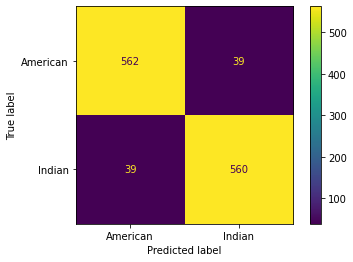

In [46]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

conf = confusion_matrix(actual_labels , pred_labels)
cm_display = metrics.ConfusionMatrixDisplay(conf, display_labels = ['American', 'Indian'])

cm_display.plot()
plt.show()